# Unrolling of GAN


In [1]:
from IPython.display import HTML
from celluloid import Camera
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.nn.utils import clip_grad_norm_

from models import Generator, Discriminator
import copy

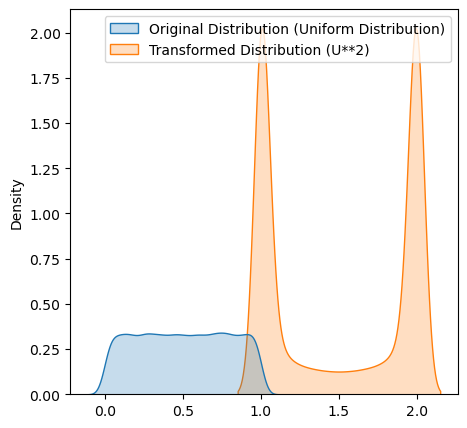

In [2]:
num_samples = 32000
u = np.array([np.random.rand() for i in range(num_samples)])
x = np.array([1+(i**10) for i in u]+[2-(i**10) for i in u])

dic = {'Original Distribution (Uniform Distribution)': u,
       'Transformed Distribution (U**2)' : x}
plt.figure(figsize=(5,5))
sns.kdeplot(dic, fill = True)
plt.show()

In [3]:
latent_dim = 10
output_dim = 1
batch_size = 512

In [4]:
gen = Generator(latent_dim, output_dim)
disc = Discriminator(output_dim)

In [5]:
gen_opt = Adam(gen.parameters(), lr = 1e-4, betas=(0, 0.999))
disc_opt = Adam(disc.parameters(), lr = 1e-4, betas=(0, 0.999))

In [6]:
x = x.reshape(-1, batch_size, 1)
x.shape

(125, 512, 1)

In [7]:
celoss = torch.nn.BCELoss()

In [8]:
epochs = 5000
disc_steps = 10
lookaheads = 5

fig = plt.figure()
plt.xlim(-0.5,3)
plt.ylim(0,3)
camera = Camera(fig)
for epoch in range(epochs):
    gen.train()
    x = x.reshape(-1, 1)
    np.random.shuffle(x)
    x = x.reshape(-1, batch_size, 1)
    disc_score_list = []
    
    ## Discriminator ##
    for idx in range(disc_steps):
        batch_idx = np.random.randint(0,len(x))
        batch = torch.tensor(x[batch_idx], dtype=torch.float32)
        z = torch.randn(size = (batch_size, latent_dim), dtype=torch.float32)
        fake_pred = torch.mean(disc(gen(z)))
        real_pred = torch.mean(disc(batch))
        
        disc_score = (real_pred-fake_pred)
        disc_score_list.append(torch.mean(disc_score).item())
        disc_score.backward()
        clip_grad_norm_(disc.parameters(), 1)
        disc_opt.step()
        disc_opt.zero_grad()
        gen_opt.zero_grad()
    disc_score = np.mean(disc_score_list)
    
    ## Generator ##
    disc_dummy = copy.deepcopy(disc)
    disc_dummy_opt = copy.deepcopy(disc_opt)
    for k in range(lookaheads):
        batch_idx = np.random.randint(0,len(x))
        batch = torch.tensor(x[batch_idx], dtype=torch.float32)
        z = torch.randn(size = (batch_size, latent_dim), dtype=torch.float32)
        fake_pred = disc_dummy(gen(z))
        real_pred = disc_dummy(batch)
        
        disc_dummy_score = (torch.mean(real_pred)-torch.mean(fake_pred))
        disc_dummy_score.backward(create_graph = True)
        clip_grad_norm_(disc_dummy.parameters(), 1)
        
        disc_dummy_opt.step()
        disc_dummy_opt.zero_grad()
    
    
    z = torch.randn(size = (batch_size, latent_dim), dtype=torch.float32)
    gen_score = torch.mean(disc_dummy(gen(z)))
    clip_grad_norm_(disc_dummy.parameters(), 1)
    clip_grad_norm_(gen.parameters(), 1)
    gen_score.backward()
    gen_opt.step()
    gen_opt.zero_grad()
    
    del disc_dummy
    del disc_dummy_opt
            
    if (epoch+1)%10 == 0 or epoch == 0:
        gen.eval()
        z = torch.randn(size=(num_samples, latent_dim), requires_grad=False)
        x_gen = gen(z).detach().numpy().reshape(-1)
        map_final = {'Original Distribution': x.reshape(-1), 'Generator Distribution': x_gen}
        plot = sns.kdeplot(map_final, fill = True) 
        camera.snap()
    if (epoch+1) % 100 == 0:
        print(f"{epoch+1}/{epochs} Discriminator : {disc_score:.2f} \t Generator : {torch.mean(gen_score).item():.2f}")
plt.close()

/Users/sohamdandapath/miniconda/lib/python3.10/site-packages/torch/autograd/__init__.py:200: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1678454852765/work/torch/csrc/autograd/engine.cpp:1156.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


100/5000 Discriminator : -9.94 	 Generator : -1.54
200/5000 Discriminator : -2.79 	 Generator : 6.64
300/5000 Discriminator : 0.77 	 Generator : -3.87
400/5000 Discriminator : -3.07 	 Generator : -5.17
500/5000 Discriminator : -4.61 	 Generator : -49.40
600/5000 Discriminator : -4.33 	 Generator : -33.67
700/5000 Discriminator : -1.50 	 Generator : -28.15
800/5000 Discriminator : -7.33 	 Generator : -37.79
900/5000 Discriminator : -12.93 	 Generator : -68.78
1000/5000 Discriminator : -15.44 	 Generator : -81.25
1100/5000 Discriminator : -16.59 	 Generator : -89.75
1200/5000 Discriminator : -16.17 	 Generator : -88.11
1300/5000 Discriminator : -15.94 	 Generator : -101.69
1400/5000 Discriminator : -15.91 	 Generator : -109.53
1500/5000 Discriminator : -17.85 	 Generator : -106.22
1600/5000 Discriminator : -17.90 	 Generator : -119.30
1700/5000 Discriminator : -19.07 	 Generator : -130.23
1800/5000 Discriminator : -18.88 	 Generator : -146.30
1900/5000 Discriminator : -19.73 	 Generator 

<Axes: ylabel='Density'>

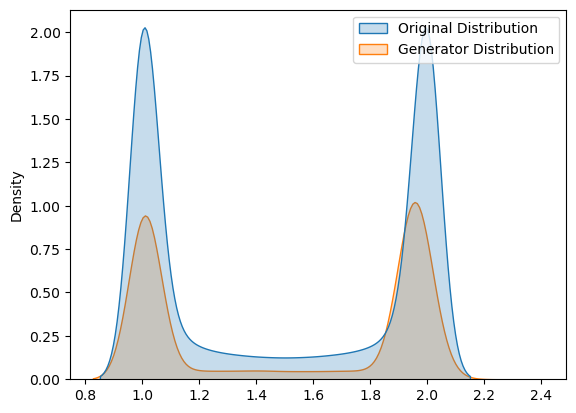

In [9]:
gen.eval()
z = torch.randn(size=(num_samples, latent_dim), requires_grad=False)
x_gen = gen(z).detach().numpy().reshape(-1)
map_final = {'Original Distribution': x.reshape(-1), 'Generator Distribution': x_gen}
sns.kdeplot(map_final, fill = True) 

In [10]:
animation = camera.animate(repeat=False)
HTML(animation.to_html5_video())